In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from keras.models import model_from_json

from sklearn.preprocessing import LabelEncoder

## Part 2: Segementing license characters

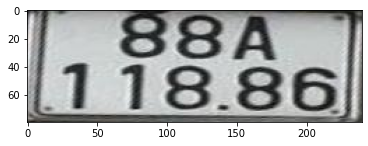

In [3]:
plate_image = cv2.imread("new.jpg")
plt.imshow(plate_image)

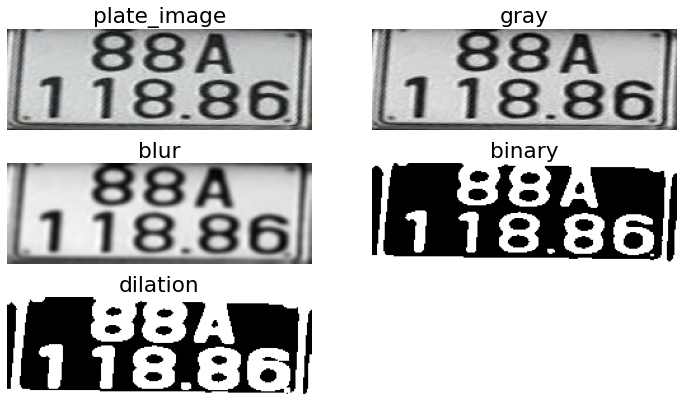

In [4]:
# convert to grayscale and blur the image
image = cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)

# Applied inversed thresh_binary 
binary = cv2.threshold(blur, 180, 255,
                        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")


In [13]:
# creat a copy version of plat_image to draw bounding box
image_copy = copy.deepcopy(plate_image)


#Find contours
cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(type(cont))
print(len(cont))
print(len(cont[0]))
print(len(cont[0][0]))
print(len(cont[0][0][0]))
print(type(cont[0]))
print(cont[0])


<class 'tuple'>
9
4
1
2
<class 'numpy.ndarray'>
[[[219  72]]

 [[219  73]]

 [[221  73]]

 [[221  72]]]


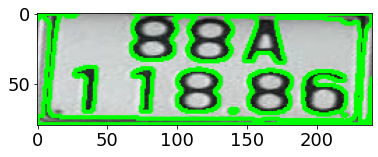

In [7]:
image = cv2.drawContours(image_copy, cont, -1, (0, 255, 0), 2)
plt.imshow(image)


In [9]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts



0 0 240 80 1.0
19 0 10 3 0.0375
26 38 17 33 0.4125
68 39 16 32 0.4
100 39 32 32 0.4
138 68 6 4 0.05
151 40 32 32 0.4
190 41 32 32 0.4
219 72 3 2 0.025
Detect 8 letters...


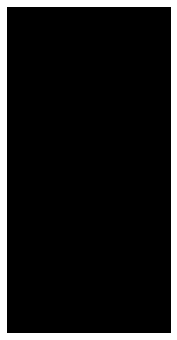

In [26]:
# Create copy
image_copy = copy.deepcopy(plate_image)
# print(plate_image.shape)

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/plate_image.shape[0]
    print(x,y,w,h, ratio)
    if ratio<=0.9: # Select contour which has the height larger than 50% of the plate
        # Draw bounding box arroung digit number
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255,0), 2)

        # Sperate number and gibe prediction
        curr_num = thre_mor[y:y+h,x:x+w]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        # _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(crop_characters[0], cmap="gray")

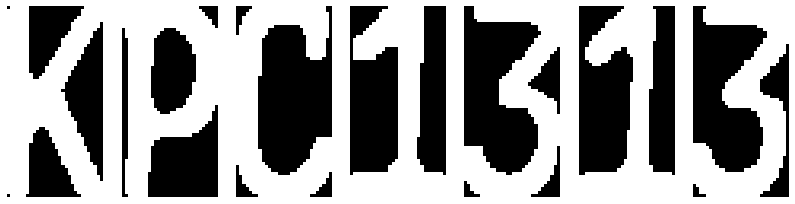

In [32]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

## Load pre-trained MobileNets model and predict

In [5]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [6]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

KPC1313


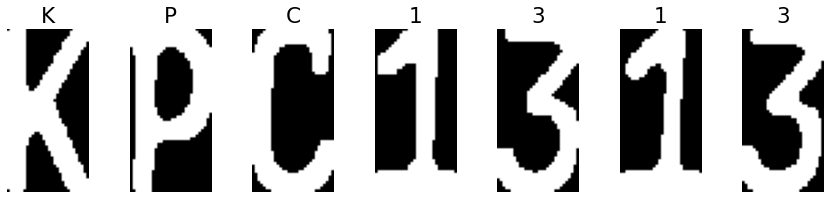

In [86]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
#plt.savefig('final_result.png', dpi=300)

# The end!